# Parallel-CPU

# Code

In [2]:
######### Set the Variables ############

# Size of the lattice:
lattice_n = 128
lattice_m = 128

seed_no = 1234 # Seed no.

# No. of Steps
eq_steps = 100 # equlibration steps
mc_steps = 1000 # monte carlo steps

# Parameters
J=1 # Interaction constant
h=0 # external magnetic field

# For calculation of the mean of observables:
n1 = 1.0/(mc_steps*lattice_n*lattice_m)
n2 = 1.0/(mc_steps*mc_steps*lattice_n*lattice_m)

np.random.seed(seed_no) # Set the seed no.

# Temperatures
temp = 2.0
inv_temp = 1/temp # inverse temperature
inv_temp_sq = inv_temp*inv_temp # squared inverse temperature

######### Start of the Simulation ############

lattice_black = generate_lattice(lattice_n, lattice_m//2)
lattice_white = generate_lattice(lattice_n, lattice_m//2)
initial_lattice = combine_lattice(lattice_black, lattice_white).copy()
    
# Equilibration
for i in range(eq_steps):
    randvals = generate_array(lattice_n, lattice_m//2)
    mc_move(lattice_black, lattice_white, randvals, True, inv_temp, J, h)

    randvals = generate_array(lattice_n, lattice_m//2)
    mc_move(lattice_white, lattice_black, randvals, True, inv_temp, J, h)

E1 = M1 = E2 = M2 = 0 # For the observables
# Start of calculation
for i in range(mc_steps):
    randvals = generate_array(lattice_n, lattice_m//2)
    mc_move(lattice_black, lattice_white, randvals, True, inv_temp, J, h)

    randvals = generate_array(lattice_n, lattice_m//2)
    mc_move(lattice_white, lattice_black, randvals, False, inv_temp, J, h)

    Ene = calc_energy(lattice_black, lattice_white, True, J, h) + calc_energy(lattice_white, 
                                                                        lattice_black, False, J, h)
    Mag = calc_mag(lattice_black) + calc_mag(lattice_white)

    E1 += Ene
    M1 += Mag
    M2 += Mag*Mag 
    E2 += Ene*Ene

E = n1*E1 # Internal Energy
M = n1*M1 # Magnetization
C = (n1*E2 - n2*E1*E1)*inv_temp_sq # Specific Heat
X = (n1*M2 - n2*M1*M1)*inv_temp # Magnetic Susceptibility

# Combine the 2 arrays to form the lattice
lattice = combine_lattice(lattice_black, lattice_white)

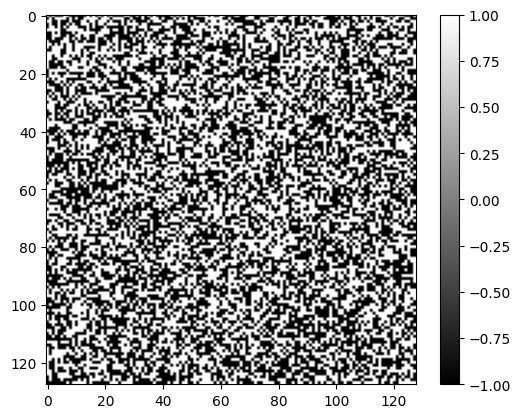

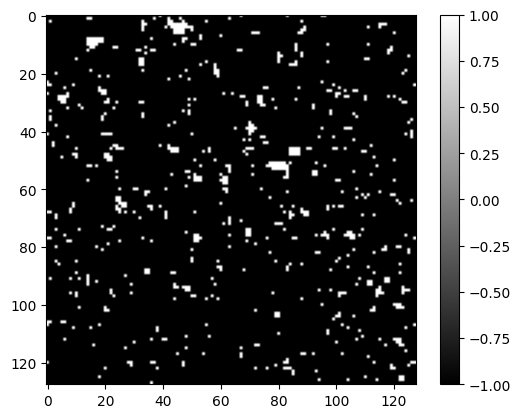

In [4]:
plot_ising(initial_lattice)
plot_ising(lattice)

# Packages

In [3]:

import matplotlib.pyplot as plt


# Functions and Variables

In [1]:
import numpy as np
from numba import njit, prange

def generate_lattice(N, M):
    """
    Create an array of size (N, M) with random values of -1, +1
    
    Parameters:
    -----------
    N: int
        no. of rows
    M: int
        no. of columns
        
    Returns:
    ---------
    array
        The lattice containing random spins
    """
    
    return np.random.choice(np.array([-1,1], dtype=np.int8),size=(N,M))

def generate_array(N, M):
    """
    Create an array of size (N, M) with random values from 0 to 1
    
    Parameters:
    -----------
    N: int
        no. of rows
    M: int
        no. of columns
        
    Returns:
    ---------
    array
        The lattice containing random values from 0 to 1
    """
    
    return np.random.rand(N, M)

@njit(parallel=True)
def mc_move(lattice, op_lattice, randvals, is_black, inv_temp, J, h):    
    """
    Perform 1 Monte Carlo sweep using the checkerboard Metropolis algorithm through numba compilation
    
    Parameters:
    -----------
    lattice: array
        The lattice to perform an MC sweep on
    op_lattice: array
        The opposite lattice corresponding to the neighbors of the lattice
    randvals: array
        Array containing float values to be used for the Metropolis criterion
    is_black: bool
        A boolean telling us what color is the lattice. If True, the array is the black lattice.
        If False, the array is the white lattice.
    inv_temp: float
        The inverse temperature of the system
    J: float
        Interaction constant
    h: float
        External magnetic field
        
    Returns
    -------
    array
        The lattice after performing 1 MC sweep
    """
    
    n,m = lattice.shape
    for i in prange(n):
        for j in prange(m):
            # Periodicity for neighbors out of index
            ipp = (i + 1) if (i + 1) < n else 0
            jpp = (j + 1) if (j + 1) < m else 0
            inn = (i - 1) if (i - 1) >= 0 else (n - 1)
            jnn = (j - 1) if (j - 1) >= 0 else (m - 1)  
           
            # Choose the index that is not in the current column,
            # depending on the color and whether the row index is even or odd.
            if (is_black):
                joff = jpp if (i % 2) else jnn
            else:
                joff = jnn if (i % 2) else jpp
                
            # Compute sum of nearest neighbor spins
            nn_sum = op_lattice[inn, j] + op_lattice[i, j] + op_lattice[ipp, j] + op_lattice[i, joff]
            
            # Compute sum of nearest neighbor spins (taking values from neighboring
            spin = lattice[i, j]
            delta_E = -2*spin*(J*nn_sum+h)
            if delta_E >= 0:
                lattice[i, j] = -spin
            elif randvals[i, j] < np.exp(delta_E*inv_temp):
                lattice[i, j] = -spin
    return lattice

@njit(parallel=True)
def calc_energy(lattice, op_lattice, is_black, J, h):
    """
    Calculates the total internal energy of a given configuration in parallel through numba compilation
    
    Parameters:
    -----------
    lattice: array
        The lattice to calculate the energy on
    op_lattice: array
        The opposite lattice corresponding to the neighbors of the lattice
    is_black: bool
        A boolean telling us what color is the lattice. If True, the array is the black lattice.
        If False, the array is the white lattice.
    J: float
        Interaction constant
    h: float
        External magnetic field
        
    Returns
    -------
    float
        The calculated total energy of the lattice
    """
    
    n,m = lattice.shape
    energy = 0
    for i in prange(n):
        for j in prange(m):
            # Periodicity for neighbors out of index
            ipp = (i + 1) if (i + 1) < n else 0
            jpp = (j + 1) if (j + 1) < m else 0
            inn = (i - 1) if (i - 1) >= 0 else (n - 1)
            jnn = (j - 1) if (j - 1) >= 0 else (m - 1)  
           
            # Choose the index that is not in the current column,
            # depending on the color and whether the row index is even or odd.
            if (is_black):
                joff = jpp if (i % 2) else jnn
            else:
                joff = jnn if (i % 2) else jpp
                
            # Compute sum of nearest neighbor spins
            nn_sum = op_lattice[inn, j] + op_lattice[i, j] + op_lattice[ipp, j] + op_lattice[i, joff]
            
            spin = lattice[i,j]
            energy += ((-J*nn_sum*spin)-(h*spin))
    return energy/2.

def calc_mag(lattice):
    """
    Return the total magnetization of a given configuration through numba compilation
    
    Parameters:
    -----------
    lattice: array
        The lattice is the configuration to be calculated
        
    Returns
    --------
    int
        The total magnetization of the lattice
    """
    return np.sum(lattice, dtype=np.int64)

@njit(parallel=True)
def combine_lattice(lattice_black, lattice_white):
    """
    Combines the black and white array to form the whole lattice
    
    Parameters
    ----------
    lattice_black: array
        The 1st array that corresponds to the non-interacting spins of the lattice
    lattice_white: array
        The 2nd array that corresponds to the non-interacting spins of the lattice
    
    Returns
    ---------
    array
        The whole lattice
    """
    
    n = lattice_black.shape[0]
    m = lattice_white.shape[0]
    lattice = np.zeros((n, m), dtype=np.int8)
    for i in prange(n):
        for j in prange(m // 2):
            if (i % 2):
                lattice[i, 2*j+1] = lattice_black[i, j]
                lattice[i, 2*j] = lattice_white[i, j]
            else:
                lattice[i, 2*j] = lattice_black[i, j]
                lattice[i, 2*j+1] = lattice_white[i, j]
    return lattice
        
def plot_ising(lattice):
    plt.imshow(lattice, cmap='gray', vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()
    
    
def set_seed():
    if use_common_seed:
        np.random.seed(common_seed)
    else:
        np.random.seed(seed)

# Plot

In [ ]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T_desc, E, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T_desc, abs(M), marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T_desc, C, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T_desc, X, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');

# Formulas

## Hamiltonian
$$H = - J \sum_{\langle i j\rangle}s_i s_j - h \sum_i s_i$$
## Mean Internal Energy
$$\langle U \rangle = \frac{H}{2N}$$
$$\langle U\rangle = \frac{1}{2N}\left(- J \sum_{\langle i j\rangle}^N s_i s_j - h \sum_i^N s_i\right)$$
## Mean Magnetization
$$\langle M \rangle = \frac{1}{N}\sum_i^N s_i$$
## Absolute Mean Magnetization
$$\langle |M| \rangle = \bigg|\frac{1}{N}\sum_i^N s_i\bigg|$$
## Specific Heat per spin
$$\langle C\rangle = \frac{1}{k_B T^2} (\langle U^2\rangle - \langle U\rangle^2)$$
## Magnetic Susceptibility per spin
$$\langle \chi\rangle = \frac{1}{k_B T}(\langle M^2\rangle - \langle M^2\rangle)$$